In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
data1 = pd.read_csv('data/data1.csv', header=None)

In [3]:
data1.head()

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


This dataset contains information about college admissions of students based on their performance on 2 exams.  

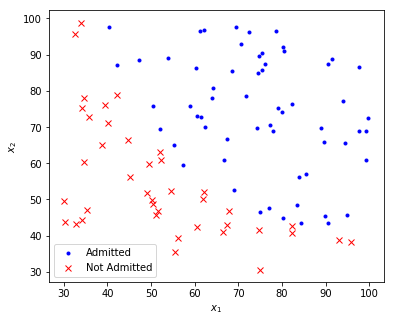

In [4]:
pos_subset = data1[data1[2] == 1]
neg_subset = data1[data1[2] == 0]

plt.figure(figsize=(6,5))
plt.plot(pos_subset[0], pos_subset[1], 'b.', 
         label = 'Admitted')
plt.plot(neg_subset[0], neg_subset[1], 'rx',
         label = 'Not Admitted')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'best')
plt.show()

This task is quite simple and doesn't require powerful techniques. We will use logistic regression algorithm trained on 2 features.

In [5]:
X = data1.iloc[:,:2]
y = data1[2]

mu = np.array(X.mean())
sigma = np.array(X.std())

Normalization is not required for this dataset, because features are in the same range 30 < x < 100.
But it could be useful later.

In [6]:
def Normalize(x, mu, sigma):
    x = np.array(x, dtype = 'float32')
    x = (x - mu) / sigma
    return x

In [7]:
class LogisticRegression():
    """
    
    Create a logistic regression model to perform binary
    or multilabel classification tasks. 
    
    """
    
    def __init__(self, data_X, data_y):
        self.X = np.insert(data_X if type(data_X) == np.ndarray \
                           else np.array(data_X), 0, 
                           np.ones(data_X.shape[0]), axis = 1)
        self.y = data_y if type(data_y) == np.ndarray \
                    else np.array(data_y)
        self.m, self.n = (self.X).shape
        self.theta_initial = np.array([0] * self.n)
        self.theta_trained = np.array([0] * self.n)
        self.labels = np.unique(self.y)
        
    def Hypothesis(self, theta, X):
        return 1/(1 + np.exp(-np.dot(X, theta.T)))
    
    def CostFunc(self, theta = None, X = None, y = None, lmbda = 0):
        if isinstance(theta, np.ndarray) == False:
            theta = self.theta_initial
        if isinstance(X, np.ndarray) == False:
            X = self.X
        if isinstance(y, np.ndarray) == False:
            y = self.y 
        
        reg_term = 0
        if lmbda != 0:
            reg_term = lmbda/(2 * self.m) * np.sum(theta**2)
            
        unit_costs = -y * np.log(self.Hypothesis(theta, X))\
            - (1 - y) * np.log(1 - self.Hypothesis(theta, X))   
        return 1/self.m * (np.sum(unit_costs) + reg_term)
    
    def Grad(self, theta = None, X = None, y = None, lmbda = 0):
        if isinstance(theta, np.ndarray) == False:
            theta = self.theta_initial
        if isinstance(X, np.ndarray) == False:
            X = self.X
        if isinstance(y, np.ndarray) == False:
            y = self.y 
   
        reg_term = 0
        if lmbda != 0:
            reg_term = lmbda * theta
            reg_term[0]-= 0
        return 1/self.m * (np.dot((self.Hypothesis(theta, X)\
                                         - y), X) + reg_term)
    
    def Fit(self, lmbda = 0, optimizer = 'TNC'):
        """
        Train the model. Default version utilize TNC algorithm for 
        minimization. Initial guess is assumed to be an array of zeros.
        To enable regularization just pass a value of lambda.
        Multilabel classification strategy: 1 vs all
        """
        labels = np.unique(self.y)
        multilabel = len(labels) > 2                                       # Is multilabel classification?
        
        if multilabel:
            theta = np.zeros((len(labels), self.X.shape[1]))
            for i in range(len(labels)):
                y_local = (self.y == labels[i]) * 1

                args_ = (self.X, y_local, lmbda)
                res = optimize.minimize(fun=self.CostFunc, args = args_,
                                                  x0=self.theta_initial,
                                                  method=optimizer,
                                                  jac=self.Grad)
                theta[i] = res.x
            self.theta_trained = theta
            print("The model was trained")
        else:
            args_ = (self.X, y, lmbda)
            res = optimize.minimize(fun=self.CostFunc, args = args_,
                                              x0=self.theta_initial,
                                              method=optimizer,
                                              jac=self.Grad)
            if res.success == True:
                self.theta_trained = np.array(res.x)
                print('The model was trained successfuly!\n' +
                     'Number of iterations: ' + str(res.nit))
            else:
                self.theta_trained = np.array(res.x)
                print('Optimization terminated with messge:\n' + res.message +
                     ",\nWeights are not optimal")
    
    def Weights(self):
        return self.theta_trained
    
    def Predict(self, x):
        """
        To get an integer prediction this method uses round function.
        So for binary classification the boundary is >= 0.5 for label
        "1" and "0" otherwise. 
        """            
        if type(x) != np.array:
            x = np.array(x, dtype = 'float32')
        if x.ndim == 1:
            x = np.insert(x, 0, 1, axis = 0)
        else:
            x = np.insert(x, 0, np.ones(x.shape[0]), axis = 1)
        
        if len(self.labels) > 2:
            pred_mat = self.Hypothesis(self.theta_trained, x)
            ids_of_max = np.argmax(pred_mat, axis = 1)
            pred = np.array([self.labels[i] for i in ids_of_max]) 
            return pred
        else:
            return np.round(self.Hypothesis(self.theta_trained, x))
    
    def Accuracy(self, test_x, test_y):
        if type(test_x) != np.ndarray:
            test_x = np.array(test_x)

        pred = self.Predict(test_x)
        print("Accuracy: {0:.2f}".format(np.mean(pred == test_y) * 100) + '%')    

In [8]:
a = LogisticRegression(X, y)

In [9]:
a.Fit()

The model was trained successfuly!
Number of iterations: 17


In the picture above you can see that classes can be easily separated by straight line given by the equation y = kx + b. So let's try to visualize this decision boundary.

In [10]:
weights = a.Weights()
x_db = np.array([np.min(X.iloc[:,0]) - 2, np.max(X.iloc[:,0]) + 2])
y_db = -1/weights[2] * (weights[1] * x_db + weights[0])

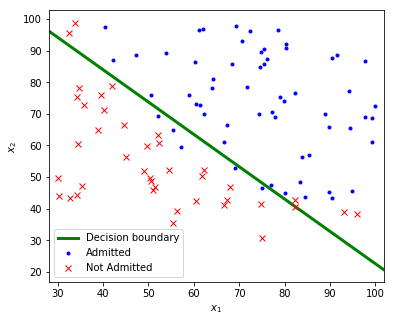

In [11]:
plt.figure(figsize=(6,5))
plt.plot(x_db, y_db, color = 'green', linewidth = 3,
        label = 'Decision boundary')
plt.plot(pos_subset[0], pos_subset[1], 'b.', 
         label = 'Admitted')
plt.plot(neg_subset[0], neg_subset[1], 'rx',
         label = 'Not Admitted')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'best')
plt.xlim(x_db[0], x_db[1])
plt.show()

# Complex shape of decision boundary

In [12]:
data2 = pd.read_csv('data/data2.csv', header=None)

In [13]:
data2.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


Imagine we are at the factory. This dataset represent information whether the product is defective or not based on results of two tests. If results lie in a certain range, then the product is accepted and goes on sale.

In [14]:
X = data2.iloc[:,:2]
y = data2.iloc[:, 2]

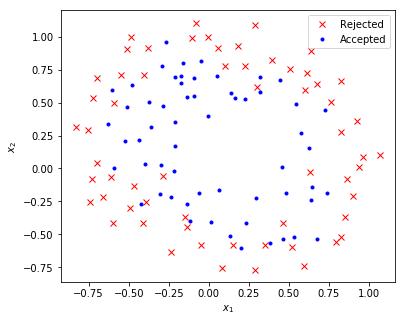

In [15]:
plt.figure(figsize=(6,5))
plt.plot(X[y == 0][0],X[y == 0][1], 'rx',
        label = 'Rejected')
plt.plot(X[y == 1][0],X[y == 1][1], 'b.',
        label = 'Accepted')
plt.legend(loc = 'best')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Now the classes can't be separated by a straight line. Here should be a curve of higher order. For example, a circle $x^2$ + $y^2$ = $R^2$ could be not a bad approximation. But to better fit the shape it's necessary to generate new features.

In [16]:
def FeatureMap(X_1, X_2, N):
    """ 
    
    Return a new table with more features. Increase number of fe- 
    atures of X from 2 to (N + 3) * N/2 by mapping input features 
    to polynomial with order N.
    
    """
    if type(X_1) != np.ndarray:
        X_1 = np.array(X_1, ndmin=2)
        X_2 = np.array(X_2, ndmin=2)
    if X_1.ndim != 2 or X_2.ndim != 2:
        np.reshape(X_1, (X_1.shape[0],1))
        np.reshape(X_2, (X_2.shape[0],1))
        
    X = np.vstack((X_1, X_2)).T
    for i in range(2, N + 1):
        for j in range(i + 1):
            X = np.hstack((X,(X_1 ** (i - j) * (X_2 ** (j))).T))
    return X

In [17]:
def ComputeZ(u, v, weights, N):
    z = np.zeros((len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = np.dot(np.insert(FeatureMap(u[i], v[j], N), 0, 1),
                            model.Weights())
    return z

In [18]:
order = 6
lmbda = 1

X_train = FeatureMap(X[0],X[1], order)
model = LogisticRegression(X_train, y)
model.Fit(lmbda)

Optimization terminated with messge:
Linear search failed,
Weights are not optimal


In [19]:
model.Weights()

array([ 1.14796988,  0.60123605,  1.17054684, -1.88314302, -0.91466193,
       -1.26549986,  0.1267369 , -0.36683793, -0.34725934, -0.18060678,
       -1.42423097, -0.05779677, -0.60630952, -0.26718966, -1.16593269,
       -0.23500923, -0.20754922, -0.05006263, -0.27921474, -0.28299029,
       -0.47646176, -1.02992508,  0.0241116 , -0.29378828,  0.01238152,
       -0.32816826, -0.13343803, -0.93372164])

In [20]:
model.Accuracy(X_train, y)

Accuracy: 83.05%


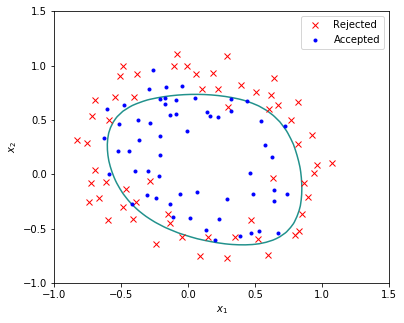

In [21]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = ComputeZ(u, v, model.Weights(), order)
        
X = data2.iloc[:,:-1]

plt.figure(figsize=(6,5))
plt.plot(X[y == 0][0], X[y == 0][1], 'rx', label = 'Rejected')
plt.plot(X[y == 1][0], X[y == 1][1], 'b.', label = 'Accepted')
plt.contour(u,v,z,0)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'best')
plt.show()

Here we can see that without regularization weights of the model are quite large with values in range $10^1$ - $10^2$ (for Feature Map with polynomial order of 6). Using parameter $\lambda$ = 1 gives us much smaller values of weights lying in the range $10^{-2}$ - $10^0$. In this case shape of the curve is much smoother which means less overfitting, due to the fact that model don't go through each data point very agressively. This technique helps to generalize training dataset. Of course, increasing regularization parameter leads to decreasing of accuracy, but it's not always a bad sign (only if we use not very large $\lambda$. Otherwise generalization ability of the model and its accuracy both decrease) 

# Multilabel classification

In [22]:
data3 = pd.read_csv('data/iris.csv')

In [23]:
data3.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


That is one of the most popular tiny dataset for multilabel classification. Iris dataset collected to quantify the morphologic variation of Iris flowers of three related species. It has 4 features so we can't visualize it on a single graph as we did earlier.

In [24]:
X = data3.iloc[:,0:4]
y = data3.iloc[:,-1]
labels = y.unique()

In [25]:
X[y == labels[1]].head()

,sepal.length,sepal.width,petal.length,petal.width
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5


To do multilabel classification I updated class object LogisticRegression and added the following functions. They were implemented a little bit different to match the structure of the class, but the logic is the same 

In [26]:
# def FitMultilabel(X, y):
#     labels = y.unique()
#     theta = np.zeros(len(labels), X.shape[1])
#     for i in range(len(labels)):
#         y_local = (y == labels[i]) * 1
#         optimize(X, y_local)                    <- Now it's binary classification task
#         theta[i] = weights

# def Predict(X_test):
#     pred_mat = sigmoid(np.dot(X_test, theta.T)) <- matrix of probabilities where p[i,j] represent a probability that
#                                                    i'th example belongs to class j 
#     idx_of_max = np.argmax(b, axis = 1)         <- array of classes of X_test
#     pred = [labels[i] for i in u]               <- decode classes in form of integers to its original type (for ex. str)

In [27]:
model = LogisticRegression(X, y)

In [28]:
model.Fit()

The model was trained


In [29]:
model.Accuracy(X,y)

Accuracy: 98.00%


Of course it's not very practical to measure accuracy on the same dataset on which the model was trained.